In [102]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from genetics import GeneticRemovingZeros
import utils

In [291]:
class Hungarian:
    rounding_value = 5

    def __init__(
        self,
        random_generate : bool = False,
        checkpoints_cnt : int = 10,
        minmax : tuple = (5, 15),
        data : list = [[],[]]):
        """инициализация объекта венгерского алгоритма

        Args:
            random_generate (bool, optional): генерация случайной карты. Defaults to False.
            checkpoints_cnt (int, optional): количество точек (используется только при генерации карты). Defaults to 10.
            minmax (tuple, optional): минимальное и максимальное значение времени между двумя точками (используется только при генерации карты). Defaults to (5, 15).
            data (list, optional): карта, заданная пользователем (используется при значении random_generate=False). Defaults to [[],[]].
        """
        if random_generate:
            self.start_field = np.random.randint(minmax[0], minmax[1], size=(checkpoints_cnt, checkpoints_cnt))
        else:
            self.start_field = np.array(data)

        self.max_time = self.start_field.max()+1
        np.fill_diagonal(self.start_field, self.max_time)
        self.checkpoints_cnt = self.start_field.shape[0]
        self.current_field = utils.rounding(
            field=self.start_field.copy(),
            rounding_value=self.__class__.rounding_value)


    def reduce(self) -> None:         
        """Выполнение операции вычитания минимальных значений по строкам и столбцам
        """
        self.current_field = (self.current_field.T - utils.get_min(self.current_field, True)).T
        self.current_field -= utils.get_min(self.current_field, False)
        np.fill_diagonal(self.current_field, self.max_time)


    def check(self) -> np.array:
        """Поиск возможных решений

        Returns:
            np.array: найденные решения
        """
        def recursive_search(checkpoint:int, path:list) -> None:
            """Рекурсивная проверка существования решения

            Args:
                checkpoint (int): номер точки
                path (list): маршрут
            """
            if len(path)==self.checkpoints_cnt:
                exists_path.append(path)
                return
            if checkpoint in path:
                return        
            path.append(checkpoint)        
            for value in checkpoit_times[checkpoint]:
                recursive_search(value, path.copy())                
            
        exists_path = []
        rows, columns = np.where(self.current_field==0)
        checkpoit_times = {i:[] for i in range(self.checkpoints_cnt)}
        for i, rr in enumerate(rows):
            checkpoit_times[rr].append(columns[i])
        for i in range(self.checkpoints_cnt):
            recursive_search(i, [])
        if len(exists_path)==0:
            return exists_path
        return np.unique(exists_path, axis=0)


    def postprocess(self) -> bool:
        """Функция обработки временной карты

        Returns:
            bool: количество "вычеркиваний" совпадает с количеством пунктов
        """
        genetic = GeneticRemovingZeros(self.checkpoints_cnt)
        row_columns, validation = genetic.process(self.current_field)
        #print(f'row_columns: {row_columns}')
        #print(f'validataion: {validation}')
        row_indexes = np.where(row_columns[:self.checkpoints_cnt]==1)[0]
        col_indexes = np.where(row_columns[self.checkpoints_cnt:]==1)[0]
        value = utils.cut_matrix(self.current_field, row_columns).min()
        self.current_field -= value
        self.current_field[row_indexes, :]+=value
        self.current_field[:, col_indexes]+=value
        np.fill_diagonal(self.current_field, self.max_time)
        return row_columns.sum()==self.checkpoints_cnt 


    def process(self):
        start_time = time.time()
        self.reduce()
        path = self.check()
        while not len(path):
            #print(f'Итерация {i}')
            self.postprocess()
            self.reduce()
            path = self.check()
        return path
            #print(f'time: {round(time.time()-start_time, 2)}')
        #print('Решение найдено')
        #print(self.current_field)

    
    def show_result(self, path):
        colors = ['#FFA773', '#1F7C65']
        cmap = plt.cm.colors.ListedColormap(colors)
        array = self.current_field.copy()
        array[array>0]=1
        plt.figure(figsize=(self.checkpoints_cnt, self.checkpoints_cnt))
        plt.imshow(array, cmap=cmap)
        plt.axis('off')
        # Вывод значений элементов массива на графике
        for i in range(self.current_field.shape[0]):
            for j in range(self.current_field.shape[1]):
                plt.text(j, i, str(self.start_field[i, j]), ha='center', va='center', color='black', fontsize=14)
        # Отображение маршрута с использованием plot
        coordinates = np.lib.stride_tricks.sliding_window_view(path, 2)
        coordinates = np.append(coordinates, [coordinates[-1, 1], coordinates[-1, 1]]).reshape((-1, 2))
        x_coords, y_coords = zip(*coordinates)
        plt.plot(y_coords, x_coords, marker='o',  markersize=25, color='#FFD240', label='Маршрут')
        # Отображение начальной точки маршрута
        plt.plot(coordinates[0][1], coordinates[0][0], marker='o', markersize=25, color='#FF7400', label='Начало')
         # Отображение конечной точки маршрута
        plt.plot(coordinates[-1][1], coordinates[-1][0], marker='o', markersize=25, color='#4E9600', label='Начало')
        plt.show()


[2 0 5 4 3 1]


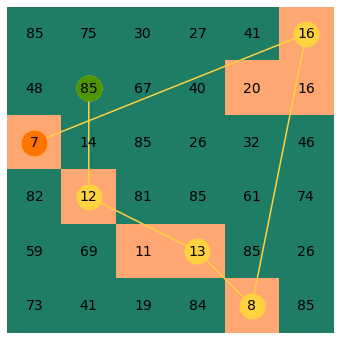

In [299]:
hung = Hungarian(random_generate=True, checkpoints_cnt=6, minmax=(7, 87))
paths = hung.process()
print(paths[0])
hung.show_result(paths[0])

In [210]:
for i in range(4, 6):
    print(f'count {i}:', end = ' ')
    ti = time.time()
    for _ in range(100):
        hung = Hungarian(random_generate=True, checkpoints_cnt=i, minmax=(4, 27))
        hung.process()
    print(f'avrg time: {round((time.time()-ti)/100, 2)}')

count 4: avrg time: 0.11
count 5: avrg time: 0.07


In [71]:
hung.postprocess()

[0 1 0 0 0 1 1 1 0 0 0 0]


In [72]:
print(hung.current_field)

[[27  0  4  6  2 14]
 [ 2 29  2 12  0  0]
 [ 0 20 25  8  6 10]
 [ 0  2  0 25 10  6]
 [ 0  6 12  4 25 12]
 [18  4  0  0  6 27]]


In [105]:
import importlib as im
import genetics
im.reload(utils)
im.reload(genetics)

from genetics import GeneticRemovingZeros

genetic = GeneticRemovingZeros(checkpoint_count=8)

In [30]:
cut_index = genetic.process(hung.current_field)
cut_index

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

In [31]:
utils.cut_matrix(hung.current_field, cut_index)

array([[27, 12, 10,  4, 16],
       [ 8, 27, 16, 16,  6],
       [ 2,  2,  8,  6,  2],
       [ 4, 10,  8, 16, 18],
       [14, 18, 16, 27, 16]])

In [32]:
hung.current_field

array([[27,  2, 14, 18,  8,  8, 22,  0],
       [10, 27, 12, 10,  0,  0,  4, 16],
       [ 6,  8, 27, 16, 16,  0, 16,  6],
       [ 8,  2, 12, 27,  4,  0,  0,  4],
       [ 0,  2,  2,  8, 27,  0,  6,  2],
       [ 0,  4, 10,  8,  4, 27, 16, 18],
       [16, 14, 18, 16,  8,  0, 27, 16],
       [ 2,  0,  0,  0, 12, 10, 14, 27]])

In [33]:
cut_index

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

In [212]:
import numpy as np

# Создаем исходный одномерный массив
original_array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Определяем ширину окна (в данном случае 2)
window_width = 2

# Создаем двумерный массив с помощью sliding_window_view
two_dimensional_array = np.lib.stride_tricks.sliding_window_view(original_array, window_width)

print(two_dimensional_array)

[[1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]
 [8 9]]
